In [46]:
# Basic imports
import os
import sys
import time
import timeit
import random
import pickle
import re
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold, LeaveOneOut, cross_validate, cross_val_score
)
from sklearn.linear_model import (
    LinearRegression, Lasso, LassoCV, MultiTaskLasso, MultiTaskLassoCV,
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.cross_decomposition import PLSRegression
from sklearn.inspection import permutation_importance


# Statistic imports 
from scipy.stats import ks_2samp
from scipy.special import kl_div
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform

# Specialized imputation and visualization packages
import miceforest as mf
import missingno as msno
#from missforest import MissForest
#import magic
from src.gain import *

# Custom modules
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning and machine learning specific 
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import xgboost as xgb
import shap

# Ignore warnings
warnings.filterwarnings("ignore")

# Print CUDA availability for PyTorch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


In [47]:
df_X_original = pd.read_pickle('../pickle/df_X_original.pickle')
df_X = pd.read_pickle('../pickle/df_X_filtered.pickle')
df_y =  pd.read_pickle('../pickle/df_y_original.pickle')
df_all = pd.read_pickle('../pickle/df_all_original.pickle')
select = pd.read_pickle('../pickle/select_features.pickle')

miss_mask = pd.read_pickle('../pickle/filter_miss_mask.pickle')
miss_mask = miss_mask.tolist()

df_X = df_X_original.drop(columns=[*select["MRIvol"], *select["PET"]])
df_X = df_X[miss_mask]
df_all = df_all[miss_mask]
df_y = df_y[miss_mask]

df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")

results_pickle_folder = "../pickle"

In [48]:
full_palette_graph = {"orange": "#ff4b41", "yellow": "#ffaa41", "blue": "#75d8ff", 
                      "cyan": "#d7d341", "purple":"#e59edd", 
                      "green":"#70d941"}
gender_palette_tab = {
    "0": full_palette_graph["green"], 
    "1": full_palette_graph["purple"]
}
dx_palette_tab = {
    "CN": "#75d8ff",
    "MCI": "#ffcc92",
    "AD": "#ff4b41", 
}

gender_palette = gender_palette_tab
dx_palette = dx_palette_tab
full_palette = full_palette_graph
sns.color_palette(list(full_palette.values()))

[(1.0, 0.29411764705882354, 0.2549019607843137),
 (1.0, 0.6666666666666666, 0.2549019607843137),
 (0.4588235294117647, 0.8470588235294118, 1.0),
 (0.8431372549019608, 0.8274509803921568, 0.2549019607843137),
 (0.8980392156862745, 0.6196078431372549, 0.8666666666666667),
 (0.4392156862745098, 0.8509803921568627, 0.2549019607843137)]

# Scikit-learn

In [49]:
def train_imputer_model(
    df_X_train, df_X_test, df_y_train, df_y_test,
    c_train, c_test,
    ordinal_model, name_ordinal_imputer, 
    continuous_model, name_continuous_imputer, 
    model, name_model, 
    imputer_model=None, name_imputer=None, 
    separate_imputers=True,
    ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
): 
    # Define which columns are ordinal and which are continuous
    continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

    # Check if a general imputer model (like MissForest or MICEForest) is provided
    if imputer_model is not None and name_imputer is not None and not separate_imputers:
        # If `imputer_model` can handle both categorical and continuous data types
        print(f"Using general imputer model: {name_imputer}")

        # Ensure that ordinal columns are marked as categorical
        df_X_train = df_X_train.copy()
        df_X_test = df_X_test.copy()
        
        for col in ordinal_features:
            df_X_train[col] = df_X_train[col].astype("category")
            df_X_test[col] = df_X_test[col].astype("category")

        # Create a pipeline with the general imputer
        pipeline = Pipeline(steps=[
            (name_imputer, imputer_model)
        ])

        # Fit and transform the entire dataset with the general imputer
        pipeline.fit(df_X_train)
        X_train_imputed = pipeline.transform(df_X_train)
        X_test_imputed = pipeline.transform(df_X_test)

        # Convert transformed output back to DataFrame with original column names
        df_X_train_imputed = pd.DataFrame(X_train_imputed, columns=df_X_train.columns)
        df_X_test_imputed = pd.DataFrame(X_test_imputed, columns=df_X_test.columns)

    else:
        # Separate imputers for ordinal and continuous data
        print("Using separate imputers for ordinal and continuous data.")

        df_X_train = df_X_train.copy()
        df_X_test = df_X_test.copy()

        # Continuous Imputation Transformer (Example: SimpleImputer)
        continuous_imputer = Pipeline([
            (name_continuous_imputer, continuous_model),
        ])

        # Ordinal Imputation Transformer (Example: KNN Imputer)
        ordinal_imputer = Pipeline([
            (name_ordinal_imputer, ordinal_model)
        ])

        # Create a ColumnTransformer to apply the appropriate imputer to each type of variable
        preprocessor = ColumnTransformer(
            transformers=[
                ('ordinal', ordinal_imputer, ordinal_features),
                ('continuous', continuous_imputer, continuous_features)
            ],
            remainder='passthrough'
        )

        # Create the pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor)
        ])

         # Separate imputers for ordinal and continuous data

        # Fit and transform, then convert back to DataFrame with original column names

        if df_X_train.isna().any().any():
                
            start = time.time()
            pipeline.fit(df_X_train)
            end = time.time()

            impute_model_time = end - start

            X_train_imputed = pipeline.transform(df_X_train)
            df_X_train_imputed = df_X_train.copy()
            df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

        else :
            print("No NaN in train data -> Keep as it is. ")
            df_X_train_imputed = df_X_train
            
            impute_model_time = None

        # Transform the test set
        if df_X_test.isna().any().any():
             
            X_test_imputed = pipeline.transform(df_X_test)
            df_X_test_imputed = df_X_test.copy()
            df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
        else : 
            print("No NaN in test data -> Keep as it is. ")
            df_X_test_imputed = df_X_test

    # Demographics adjustment for y
    demographic_adjustment_y = DemographicAdjustmentTransformer()
    
    y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
    y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

    # Demographics adjustment for X
    demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
    X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
    X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)

    # Perform prediction and save variables
    start = time.time()

    if isinstance(model, TabNetRegressor): 
        X_train_adjusted = X_train_adjusted.values
        y_train_adjusted = y_train_adjusted.values

        X_test_adjusted = X_test_adjusted.values
        #y_test_adjusted = y_test_adjusted.values
    
    model.fit(X_train_adjusted, y_train_adjusted)
    end = time.time()

    predict_model_time = end - start

    y_pred_adjusted = model.predict(X_test_adjusted)

    y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

    # Metrics computed in original space
    y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : X_train_adjusted.shape, 
        "test_shape": X_test_adjusted.shape
    }
    
    if df_X_test.shape[0] != 1: 

        # Metrics computed in adjusted space
        mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted)

        results_adj = {
            "mse_score": mse_score_adj, 
            "mae_score":mae_score_ajd, 
            "r2":r2_adj, 
            "explained_variance":explained_variance_adj, 
            "corr":corr_adj, 
        }

        mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred)

        results_org = {
            "mse_score": mse_score, 
            "mae_score": mae_score, 
            "r2": r2, 
            "explained_variance": explained_variance, 
            "corr": corr, 
        }

    else : 
        print("Saving predictions in dict!")
        results_adj = {
            "y_pred": y_pred_adjusted.values, 
            "y_test": y_test_adjusted.values,
        }

        results_org = {
            "y_pred": y_pred.values, 
            "y_test": df_y_test.values,
        }


    dict_results = {
        "params": params, 
        "imputation_time": impute_model_time,
        "fitting_time": predict_model_time, 
        "results_adj": results_adj, 
        "results_org": results_org
        }

    return dict_results


# Option 2 : Train on imputed missing data and test on complete 

This has the advantage tht it adds a bit of the complete samples to the training set, potentially capturing the interactions between missing and non-missing features. 

In [50]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True
        
df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")

df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

Define all the models and combinations to try out with their hyperparameters. 

In [51]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
    ("MultiTaskElasticNet", MultiTaskElasticNet()),
    ("MultiTaskLasso", MultiTaskLasso()),
    ("RandomForestRegressor", RandomForestRegressor()),
    ("XGBoostRegressor", XGBoostRegressor()),
    ("TabNetRegressor_default", TabNetModelWrapper(n_a=8, n_d=8)),
    ("TabNetRegressor_custom", TabNetModelWrapper(n_a=32, n_d=32)),
    ("PLSRegression_2_components", PLSRegression(n_components=2)),
    ("PLSRegression_4_components", PLSRegression(n_components=4)),
    ("PLSRegression_6_components", PLSRegression(n_components=6)),
    ("PLSRegression_10_components", PLSRegression(n_components=10))
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: MultiTaskElasticNet
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: MultiTaskLasso
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: RandomForestRegressor
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: XGBoostRegressor
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: TabNetRegressor_default
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: TabNetRegressor_custom
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: PLSRegression_2_components
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: PLSRegression_4_components
Continuous Imputer: KNNImputer, Ordinal Imp

In [52]:
# Initialize HDF5 file
results_file = '../pickle/training_2_dict_results.pickle'

if os.path.exists(results_file): 

    with open(results_file, "rb") as input_file:
        all_dict_results = pickle.load(input_file)

else : 
    all_dict_results = []
            
for continuous_imputer, ordinal_imputer, model in combinations:
    name_continuous_imputer, continuous_imputer_instance = continuous_imputer
    name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
    name_model, model_instance = model

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : df_X_train.shape, 
        "test_shape": df_X_test.shape
    }

    if any(result['params'] == params for result in all_dict_results):
        # Skip this iteration if the combination exists
        print(f"Skipping existing combination: {params.values()}")
        
        continue

    try: 
    
        # Now you can call your `train_model` function with these components
        dict_results = train_imputer_model(
            df_X_train, df_X_test, df_y_train, df_y_test,
            c_train, c_test,
            ordinal_imputer_instance, name_ordinal_imputer,
            continuous_imputer_instance, name_continuous_imputer,
            model_instance, name_model,
            separate_imputers=True  # Or however you want to specify
        )

    except Exception as e:  

        print(e)
    
        dict_results = {
        "params": params, 
        "imputation_time": None,
        "fitting_time": None, 
        "results_adj": None, 
        "results_org": None
    }
        
    # Optionally keep the all_dict_results list updated
    all_dict_results.append(dict_results)

        # Save the updated results back to the pickle file
    with open(results_file, 'wb') as f:
        pickle.dump(all_dict_results, f)


Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer', 'MultiTaskElasticNet', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer', 'MultiTaskLasso', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer', 'RandomForestRegressor', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer', 'XGBoostRegressor', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer', 'TabNetRegressor_default', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer', 'TabNetRegressor_custom', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(

In [53]:
# Store data (serialize)
with open(results_file, 'wb') as handle:
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
with open('../pickle/training_2_dict_results.pickle', "rb") as input_file:
    dict_results_split = pickle.load(input_file)

In [55]:
def missing_results_dict_to_dataframe(dict_output):

    df_results = pd.json_normalize(dict_output)

    for col in df_results.columns[df_results.columns.str.startswith("results")]:
        # Create new columns for each subcategory
        for i, subcategory in enumerate(df_y.columns):
            new_col_name = f"{col}.{subcategory}"
            df_results[new_col_name] = df_results[col].apply(lambda x: x[i] if x is not None else None)

            print(new_col_name)

        # Optionally, drop the original list column
        df_results.drop(columns=col, inplace=True)

    # Show the expanded DataFrame
    return df_results

In [56]:
df_results_split = missing_results_dict_to_dataframe(dict_results_split)
df_results_split_radar = df_results_split.melt(id_vars=df_results_split.columns[df_results_split.columns.str.startswith("params")].tolist(), value_vars=df_results_split.columns[df_results_split.columns.str.startswith("results")].tolist())

results_adj.mse_score.ADNI_MEM
results_adj.mse_score.ADNI_EF
results_adj.mse_score.ADNI_VS
results_adj.mse_score.ADNI_LAN
results_adj.mae_score.ADNI_MEM
results_adj.mae_score.ADNI_EF
results_adj.mae_score.ADNI_VS
results_adj.mae_score.ADNI_LAN
results_adj.r2.ADNI_MEM
results_adj.r2.ADNI_EF
results_adj.r2.ADNI_VS
results_adj.r2.ADNI_LAN
results_adj.explained_variance.ADNI_MEM
results_adj.explained_variance.ADNI_EF
results_adj.explained_variance.ADNI_VS
results_adj.explained_variance.ADNI_LAN
results_adj.corr.ADNI_MEM
results_adj.corr.ADNI_EF
results_adj.corr.ADNI_VS
results_adj.corr.ADNI_LAN
results_org.mse_score.ADNI_MEM
results_org.mse_score.ADNI_EF
results_org.mse_score.ADNI_VS
results_org.mse_score.ADNI_LAN
results_org.mae_score.ADNI_MEM
results_org.mae_score.ADNI_EF
results_org.mae_score.ADNI_VS
results_org.mae_score.ADNI_LAN
results_org.r2.ADNI_MEM
results_org.r2.ADNI_EF
results_org.r2.ADNI_VS
results_org.r2.ADNI_LAN
results_org.explained_variance.ADNI_MEM
results_org.explained_va

In [57]:
df_results_split = missing_results_dict_to_dataframe(dict_results_split)

df_results_split_radar = df_results_split.melt(id_vars=df_results_split.columns[df_results_split.columns.str.startswith("params")].tolist(), value_vars=df_results_split.columns[df_results_split.columns.str.startswith("results")].tolist())

df_results_split_radar["variable"] = df_results_split_radar["variable"].apply(lambda x : x.replace("_ajd_", "_"))
df_results_split_radar["result_domain"] = df_results_split_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_split_radar["metric"] = df_results_split_radar["variable"].apply(lambda x: x.split(".")[1])
df_results_split_radar["cognitive_domain"] = df_results_split_radar["variable"].apply(lambda x: x.split(".")[2])
df_results_split_radar = df_results_split_radar.drop(columns=["variable"])
df_results_split_radar["preprocessing"] =  df_results_split_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)

results_adj.mse_score.ADNI_MEM
results_adj.mse_score.ADNI_EF
results_adj.mse_score.ADNI_VS
results_adj.mse_score.ADNI_LAN
results_adj.mae_score.ADNI_MEM
results_adj.mae_score.ADNI_EF
results_adj.mae_score.ADNI_VS
results_adj.mae_score.ADNI_LAN
results_adj.r2.ADNI_MEM
results_adj.r2.ADNI_EF
results_adj.r2.ADNI_VS
results_adj.r2.ADNI_LAN
results_adj.explained_variance.ADNI_MEM
results_adj.explained_variance.ADNI_EF
results_adj.explained_variance.ADNI_VS
results_adj.explained_variance.ADNI_LAN
results_adj.corr.ADNI_MEM
results_adj.corr.ADNI_EF
results_adj.corr.ADNI_VS
results_adj.corr.ADNI_LAN
results_org.mse_score.ADNI_MEM
results_org.mse_score.ADNI_EF
results_org.mse_score.ADNI_VS
results_org.mse_score.ADNI_LAN
results_org.mae_score.ADNI_MEM
results_org.mae_score.ADNI_EF
results_org.mae_score.ADNI_VS
results_org.mae_score.ADNI_LAN
results_org.r2.ADNI_MEM
results_org.r2.ADNI_EF
results_org.r2.ADNI_VS
results_org.r2.ADNI_LAN
results_org.explained_variance.ADNI_MEM
results_org.explained_va

In [58]:
df_results_split_radar["pipeline"] =  df_results_split_radar[['params.ordinal_imputer', 'params.continuous_imputer', 'params.model']].agg('.'.join, axis=1)

In [59]:
df_plot_split_ajd = df_results_split_radar[df_results_split_radar['result_domain'] == "results_adj"]
df_plot_split_org = df_results_split_radar[df_results_split_radar['result_domain'] == "results_org"]

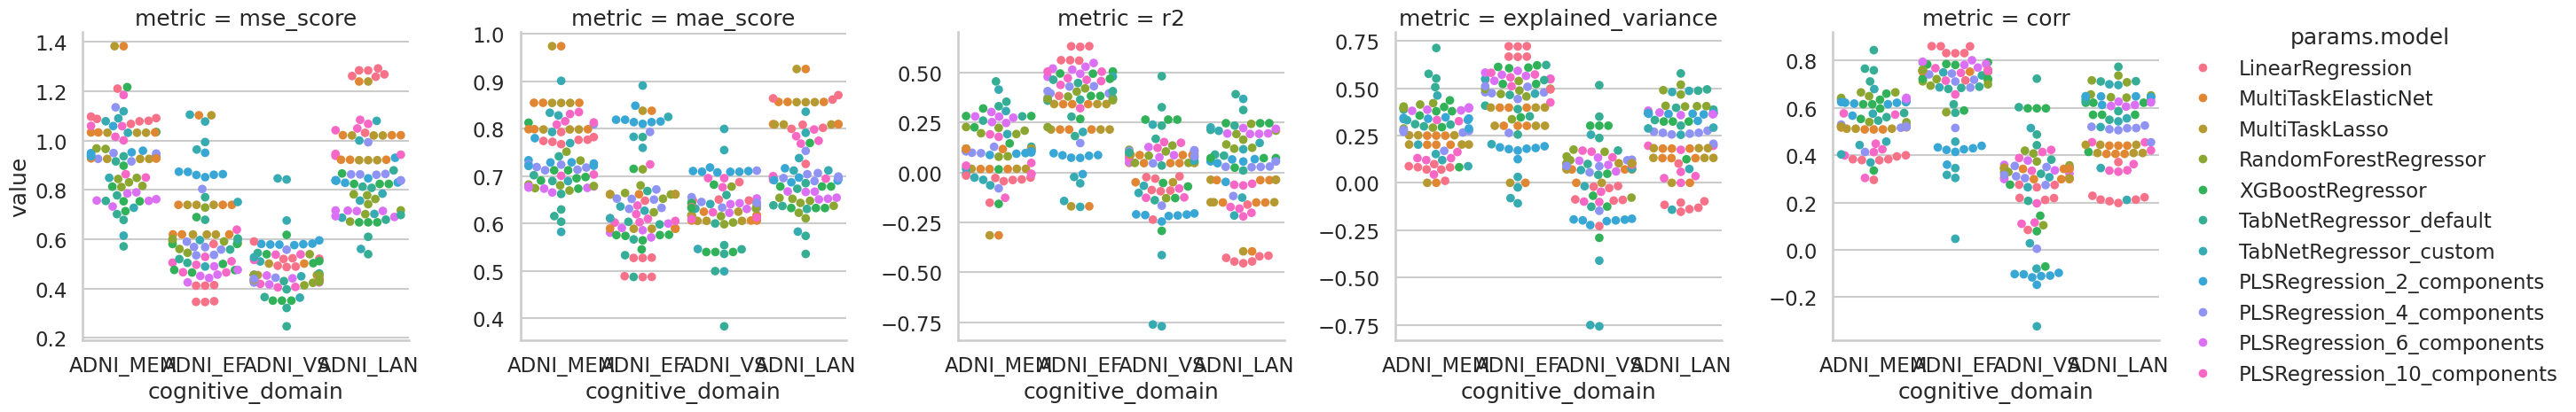

In [60]:
sns.catplot(data=df_plot_split_ajd, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

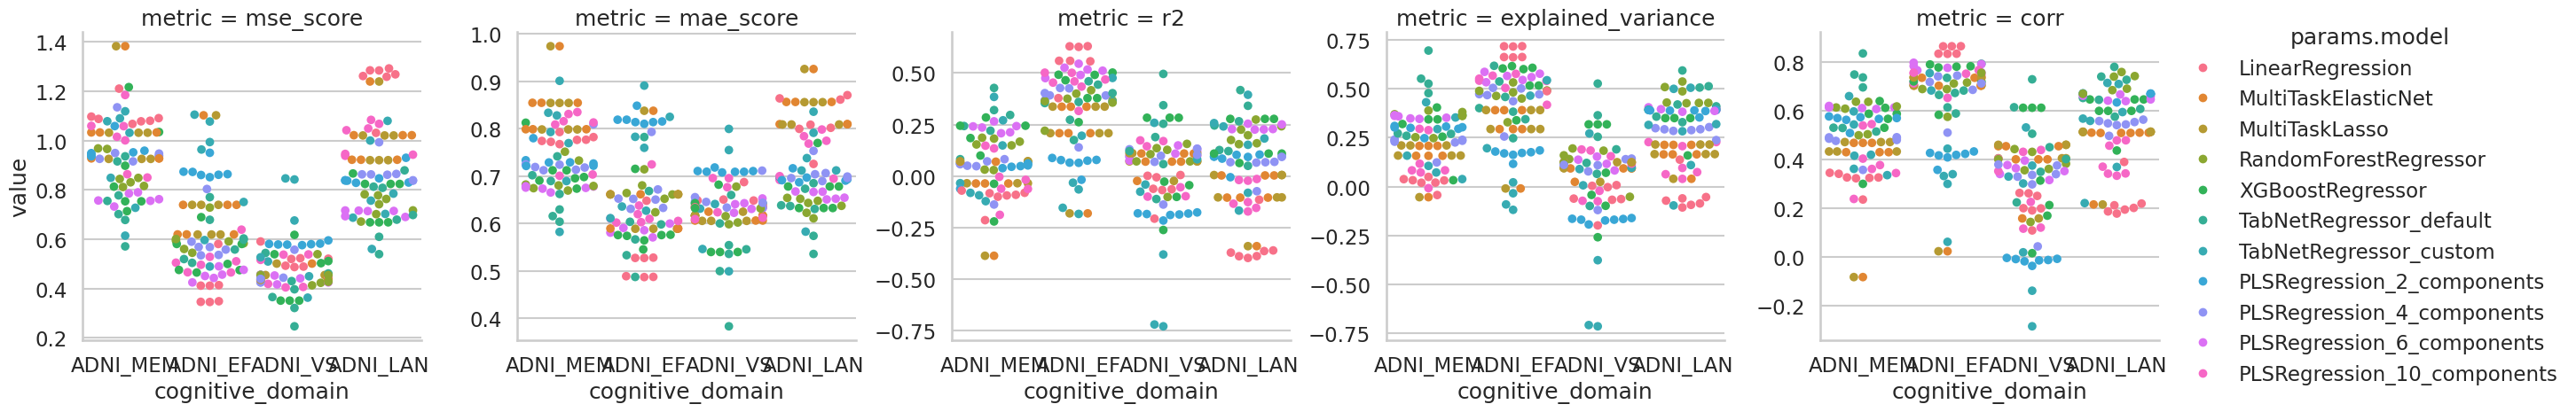

In [61]:
sns.catplot(data=df_plot_split_org, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

# Train models only on MRI features to compare performances

## Option 1 : Test train split

In [62]:
def train_imputer_model(
    df_X_train, df_X_test, df_y_train, df_y_test,
    c_train, c_test,
    ordinal_model, name_ordinal_imputer, 
    continuous_model, name_continuous_imputer, 
    model, name_model, 
    imputer_model=None, name_imputer=None, 
    separate_imputers=True,
    ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
): 
    # Define which columns are ordinal and which are continuous
    continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

    # Check if a general imputer model (like MissForest or MICEForest) is provided
    if imputer_model is not None and name_imputer is not None and not separate_imputers:
        # If `imputer_model` can handle both categorical and continuous data types
        print(f"Using general imputer model: {name_imputer}")

        # Ensure that ordinal columns are marked as categorical
        df_X_train = df_X_train.copy()
        df_X_test = df_X_test.copy()
        
        for col in ordinal_features:
            df_X_train[col] = df_X_train[col].astype("category")
            df_X_test[col] = df_X_test[col].astype("category")

        # Create a pipeline with the general imputer
        pipeline = Pipeline(steps=[
            (name_imputer, imputer_model)
        ])

        # Fit and transform the entire dataset with the general imputer
        pipeline.fit(df_X_train)
        X_train_imputed = pipeline.transform(df_X_train)
        X_test_imputed = pipeline.transform(df_X_test)

        # Convert transformed output back to DataFrame with original column names
        df_X_train_imputed = pd.DataFrame(X_train_imputed, columns=df_X_train.columns)
        df_X_test_imputed = pd.DataFrame(X_test_imputed, columns=df_X_test.columns)

    else:
        # Separate imputers for ordinal and continuous data
        print("Using separate imputers for ordinal and continuous data.")

        df_X_train = df_X_train.copy()
        df_X_test = df_X_test.copy()

        # Continuous Imputation Transformer (Example: SimpleImputer)
        continuous_imputer = Pipeline([
            (name_continuous_imputer, continuous_model),
        ])

        # Ordinal Imputation Transformer (Example: KNN Imputer)
        ordinal_imputer = Pipeline([
            (name_ordinal_imputer, ordinal_model)
        ])

        # Create a ColumnTransformer to apply the appropriate imputer to each type of variable
        preprocessor = ColumnTransformer(
            transformers=[
                ('ordinal', ordinal_imputer, ordinal_features),
                ('continuous', continuous_imputer, continuous_features)
            ],
            remainder='passthrough'
        )

        # Create the pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor)
        ])

         # Separate imputers for ordinal and continuous data

        # Fit and transform, then convert back to DataFrame with original column names

        if df_X_train.isna().any().any():
                
            start = time.time()
            pipeline.fit(df_X_train)
            end = time.time()

            impute_model_time = end - start

            X_train_imputed = pipeline.transform(df_X_train)
            df_X_train_imputed = df_X_train.copy()
            df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

        else :
            print("No NaN in train data -> Keep as it is. ")
            df_X_train_imputed = df_X_train
            
            impute_model_time = None

        # Transform the test set
        if df_X_test.isna().any().any(): 
            X_test_imputed = pipeline.transform(df_X_test)
            df_X_test_imputed = df_X_test.copy()
            df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
        else : 
            print("No NaN in test data -> Keep as it is. ")
            df_X_test_imputed = df_X_test

    # Demographics adjustment for y
    demographic_adjustment_y = DemographicAdjustmentTransformer()
    y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
    y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

    # Demographics adjustment for X
    demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
    X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
    X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)

    # Perform prediction and save variables
    start = time.time()

    if isinstance(model, TabNetRegressor): 
        X_train_adjusted = X_train_adjusted.values
        y_train_adjusted = y_train_adjusted.values

        X_test_adjusted = X_test_adjusted.values
        #y_test_adjusted = y_test_adjusted.values
    
    model.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start

    y_pred_adjusted = model.predict(X_test_adjusted)

    y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

    # Metrics computed in original space
    y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : X_train_adjusted.shape, 
        "test_shape": X_test_adjusted.shape
    }
    
    if df_X_test.shape[0] != 1: 

        # Metrics computed in adjusted space
        mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted)

        results_adj = {
            "mse_score": mse_score_adj, 
            "mae_score":mae_score_ajd, 
            "r2":r2_adj, 
            "explained_variance":explained_variance_adj, 
            "corr":corr_adj, 
        }

        mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred)

        results_org = {
            "mse_score": mse_score, 
            "mae_score": mae_score, 
            "r2": r2, 
            "explained_variance": explained_variance, 
            "corr": corr, 
        }

    else : 
        print("Saving predictions in dict!")
        results_adj = {
            "y_pred": y_pred_adjusted.values, 
            "y_test": y_test_adjusted.values,
        }

        results_org = {
            "y_pred": y_pred.values, 
            "y_test": df_y_test.values,
        }


    dict_results = {
        "params": params, 
        "imputation_time": impute_model_time,
        "fitting_time": predict_model_time, 
        "results_adj": results_adj, 
        "results_org": results_org
        }

    return dict_results


In [63]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

In [64]:
df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")

In [65]:
df_X_train = df_X[select["MRIth"]].loc[idx_train]
df_X_test = df_X[select["MRIth"]].loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

In [66]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("NoImputer", KNNImputer(n_neighbors=1)),

]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("NoImputer", SimpleImputer(strategy="most_frequent")),
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
    ("MultiTaskElasticNet", MultiTaskElasticNet()),
    ("MultiTaskLasso", MultiTaskLasso()),
    ("RandomForestRegressor", RandomForestRegressor()),
    ("XGBoostRegressor", XGBoostRegressor()),
    ("TabNetRegressor_default", TabNetModelWrapper()),
    ("TabNetRegressor_custom", TabNetModelWrapper(n_a=32, n_d=32)),
    ("PLSRegression_2_components", PLSRegression(n_components=2)),
    ("PLSRegression_4_components", PLSRegression(n_components=4)),
    ("PLSRegression_10_components", PLSRegression(n_components=10))
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: LinearRegression
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskElasticNet
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskLasso
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: RandomForestRegressor
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: XGBoostRegressor
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: TabNetRegressor_default
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: TabNetRegressor_custom
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_2_components
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_4_components
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_10_components
Combinations of preprocessing and models to test : 10


In [67]:
# Initialize HDF5 file
results_file = '../pickle/training_2_dict_results.pickle'

with open('../pickle/training_2_dict_results.pickle', "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [68]:
for continuous_imputer, ordinal_imputer, model in combinations:
    name_continuous_imputer, continuous_imputer_instance = continuous_imputer
    name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
    name_model, model_instance = model

    try: 
    
        # Now you can call your `train_model` function with these components
        dict_results = train_imputer_model(
            df_X_train, df_X_test, df_y_train, df_y_test,
            c_train, c_test,
            ordinal_imputer_instance, name_ordinal_imputer,
            continuous_imputer_instance, name_continuous_imputer,
            model_instance, name_model,
            separate_imputers=True  # Or however you want to specify
        )

    except Exception as e:  

        print(e)
    
        params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : df_X_train.shape, 
        "test_shape": df_X_test.shape
    }
        dict_results = {
        "params": params, 
        "imputation_time": None,
        "fitting_time": None, 
        "results_adj": None, 
        "results_org": None
    }
        
    # Optionally keep the all_dict_results list updated
    all_dict_results.append(dict_results)

    # Save the updated results back to the pickle file
    with open(results_file, 'wb') as f:
        pickle.dump(all_dict_results, f)


Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
epoch 0  | loss: 3.05202 |  0:00:00s
epoch 1  | loss: 1.64462 |  0:00:00s
epoch 2  | loss: 1.29186 |  0:00:00s
epoch 3  | loss: 1.10503 |  0:00:00s
epoch 4  | loss: 1.01423 |  0:00:00s

In [69]:
# Store data (serialize)
with open(results_file, 'wb') as handle:
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [70]:
with open(results_file, "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [71]:
def missing_results_dict_to_dataframe(dict_output):

    df_results = pd.json_normalize(dict_output)

    for col in df_results.columns[df_results.columns.str.startswith("results")]:
        # Create new columns for each subcategory
        for i, subcategory in enumerate(df_y.columns):
            new_col_name = f"{col}.{subcategory}"
            df_results[new_col_name] = df_results[col].apply(lambda x: x[i] if x is not None else None)

            print(new_col_name)

        # Optionally, drop the original list column
        df_results.drop(columns=col, inplace=True)

    # Show the expanded DataFrame
    return df_results

In [72]:
df_results_split = missing_results_dict_to_dataframe(all_dict_results)
df_results_split_radar = df_results_split.melt(id_vars=df_results_split.columns[df_results_split.columns.str.startswith("params")].tolist(), value_vars=df_results_split.columns[df_results_split.columns.str.startswith("results")].tolist())

results_adj.mse_score.ADNI_MEM
results_adj.mse_score.ADNI_EF
results_adj.mse_score.ADNI_VS
results_adj.mse_score.ADNI_LAN
results_adj.mae_score.ADNI_MEM
results_adj.mae_score.ADNI_EF
results_adj.mae_score.ADNI_VS
results_adj.mae_score.ADNI_LAN
results_adj.r2.ADNI_MEM
results_adj.r2.ADNI_EF
results_adj.r2.ADNI_VS
results_adj.r2.ADNI_LAN
results_adj.explained_variance.ADNI_MEM
results_adj.explained_variance.ADNI_EF
results_adj.explained_variance.ADNI_VS
results_adj.explained_variance.ADNI_LAN
results_adj.corr.ADNI_MEM
results_adj.corr.ADNI_EF
results_adj.corr.ADNI_VS
results_adj.corr.ADNI_LAN
results_org.mse_score.ADNI_MEM
results_org.mse_score.ADNI_EF
results_org.mse_score.ADNI_VS
results_org.mse_score.ADNI_LAN
results_org.mae_score.ADNI_MEM
results_org.mae_score.ADNI_EF
results_org.mae_score.ADNI_VS
results_org.mae_score.ADNI_LAN
results_org.r2.ADNI_MEM
results_org.r2.ADNI_EF
results_org.r2.ADNI_VS
results_org.r2.ADNI_LAN
results_org.explained_variance.ADNI_MEM
results_org.explained_va

In [73]:
df_results_split_radar["variable"] = df_results_split_radar["variable"].apply(lambda x : x.replace("_ajd_", "_"))
df_results_split_radar["result_domain"] = df_results_split_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_split_radar["metric"] = df_results_split_radar["variable"].apply(lambda x: "_".join(x.split(".")[1].split(".")[:2]))
df_results_split_radar["cognitive_domain"] = df_results_split_radar["variable"].apply(lambda x: "".join(x.split(".")[2]))
df_results_split_radar = df_results_split_radar.drop(columns=["variable"])
df_results_split_radar["preprocessing"] =  df_results_split_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)
df_results_split_radar["pipeline"] =  df_results_split_radar[['params.ordinal_imputer', 'params.continuous_imputer', 'params.model']].agg('.'.join, axis=1)

In [74]:
df_results_split_radar

,params.ordinal_imputer,params.continuous_imputer,params.model,params.train_shape,params.test_shape,value,result_domain,metric,cognitive_domain,preprocessing,pipeline
0,SimpleImputer_most_frequent,KNNImputer,LinearRegression,"(2882, 261)","(12, 261)",1.077550,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.LinearR...
1,SimpleImputer_most_frequent,KNNImputer,MultiTaskElasticNet,"(2882, 261)","(12, 261)",1.032492,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.MultiTa...
2,SimpleImputer_most_frequent,KNNImputer,MultiTaskLasso,"(2882, 261)","(12, 261)",1.031354,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.MultiTa...
3,SimpleImputer_most_frequent,KNNImputer,RandomForestRegressor,"(2882, 261)","(12, 261)",0.815788,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.RandomF...
4,SimpleImputer_most_frequent,KNNImputer,XGBoostRegressor,"(2882, 261)","(12, 261)",0.897634,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.XGBoost...
...,...,...,...,...,...,...,...,...,...,...,...
3435,NoImputer,NoImputer,TabNetRegressor_default,"(2882, 200)","(12, 200)",0.616612,results_org,corr,ADNI_LAN,NoImputer.NoImputer,NoImputer.NoImputer.TabNetRegressor_default
3436,NoImputer,NoImputer,TabNetRegressor_custom,"(2882, 200)","(12, 200)",0.596705,results_org,corr,ADNI_LAN,NoImputer.NoImputer,NoImputer.NoImputer.TabNetRegressor_custom
3437,NoImputer,NoImputer,PLSRegression_2_components,"(2882, 200)","(12, 200)",0.633622,results_org,corr,ADNI_LAN,NoImputer.NoImputer,NoImputer.NoImputer.PLSRegression_2_components
3438,NoImputer,NoImputer,PLSRegression_4_components,"(2882, 200)","(12, 200)",0.496479,results_org,corr,ADNI_LAN,NoImputer.NoImputer,NoImputer.NoImputer.PLSRegression_4_components


In [75]:
def df_results_radar_to_latex_pretable(df_results_preprocess_radar_, result_domain = "results_adj", scoring_metric="corr", ascending=True): 
        
        df_results_preprocess_to_latex = df_results_preprocess_radar_.drop(columns=["preprocessing", "params.train_shape", "params.test_shape"])

        df = df_results_preprocess_to_latex[df_results_preprocess_to_latex["result_domain"]== result_domain].drop(columns="result_domain")

        df_pivoted = df.pivot_table(index=['params.ordinal_imputer', 'params.continuous_imputer', 'params.model'],
                                    columns=['metric', 'cognitive_domain'],
                                    values='value',
                                    aggfunc='first')

        # Resetting index to flatten the MultiIndex
        df_pivoted.reset_index(inplace=True)
        # Flatten the MultiIndex columns temporarily for filtering
        df_pivoted.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df_pivoted.columns]

        # Select columns that start with 'params' or contain 'corr'
        columns_to_keep = [col for col in df_pivoted.columns if col.startswith('params') or scoring_metric in col]

        # Filter the dataframe
        df_filtered = df_pivoted[columns_to_keep]

        # Display the filtered dataframe
        # Add a column for the mean of each row
        # Select only the numeric columns (excluding 'params' columns)
        numeric_columns = df_filtered.select_dtypes(include='number').columns

        # Add a column for the mean of each row (across numeric columns)
        df_filtered['mean'] = df_filtered[numeric_columns].mean(axis=1)

        # Add a column for the standard deviation of each row (across numeric columns)
        df_filtered['std'] = df_filtered[numeric_columns].std(axis=1)

        return df_filtered.sort_values("mean", ascending=ascending)

In [76]:
pd.set_option('display.float_format', '{:.3f}'.format)
df_results_radar_to_latex_pretable(df_results_split_radar, result_domain="results_adj", scoring_metric="corr", ascending=False).dropna()

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,corr_ADNI_EF,corr_ADNI_LAN,corr_ADNI_MEM,corr_ADNI_VS,mean,std
74,SimpleImputer_most_frequent,KNNImputer_2,TabNetRegressor_default,0.792,0.774,0.844,0.603,0.753,0.105
9,KNNImputer,KNNImputer,TabNetRegressor_default,0.737,0.637,0.766,0.723,0.716,0.056
42,SimpleImputer_constant,KNNImputer,XGBoostRegressor,0.792,0.622,0.634,0.598,0.662,0.088
40,SimpleImputer_constant,KNNImputer,TabNetRegressor_custom,0.750,0.700,0.679,0.515,0.661,0.102
20,KNNImputer,KNNImputer_2,TabNetRegressor_default,0.684,0.712,0.759,0.487,0.660,0.119
...,...,...,...,...,...,...,...,...,...
26,NoImputer,NoImputer,PLSRegression_2_components,0.360,0.612,0.567,-0.148,0.348,0.348
27,NoImputer,NoImputer,PLSRegression_4_components,0.515,0.454,0.414,0.005,0.347,0.232
19,KNNImputer,KNNImputer_2,TabNetRegressor_custom,0.047,0.556,0.403,0.265,0.318,0.216
62,SimpleImputer_most_frequent,KNNImputer,TabNetRegressor_custom,0.345,0.211,0.443,0.028,0.257,0.180


In [77]:
pd.set_option('display.float_format', '{:.3f}'.format)
df_results_radar_to_latex_pretable(df_results_split_radar, result_domain="results_adj", scoring_metric="mae_score", ascending=True)

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,mae_score_ADNI_EF,mae_score_ADNI_LAN,mae_score_ADNI_MEM,mae_score_ADNI_VS,mean,std
9,KNNImputer,KNNImputer,TabNetRegressor_default,0.487,0.685,0.615,0.383,0.543,0.134
20,KNNImputer,KNNImputer_2,TabNetRegressor_default,0.598,0.574,0.603,0.536,0.578,0.031
74,SimpleImputer_most_frequent,KNNImputer_2,TabNetRegressor_default,0.533,0.630,0.662,0.499,0.581,0.077
40,SimpleImputer_constant,KNNImputer,TabNetRegressor_custom,0.636,0.583,0.689,0.499,0.602,0.081
42,SimpleImputer_constant,KNNImputer,XGBoostRegressor,0.564,0.632,0.673,0.540,0.602,0.061
...,...,...,...,...,...,...,...,...,...
62,SimpleImputer_most_frequent,KNNImputer,TabNetRegressor_custom,0.825,0.835,0.828,0.642,0.782,0.094
73,SimpleImputer_most_frequent,KNNImputer_2,TabNetRegressor_custom,0.783,0.791,0.833,0.755,0.790,0.033
8,KNNImputer,KNNImputer,TabNetRegressor_custom,0.890,0.738,0.769,0.799,0.799,0.066
23,NoImputer,NoImputer,MultiTaskElasticNet,0.837,0.926,0.974,0.625,0.840,0.154


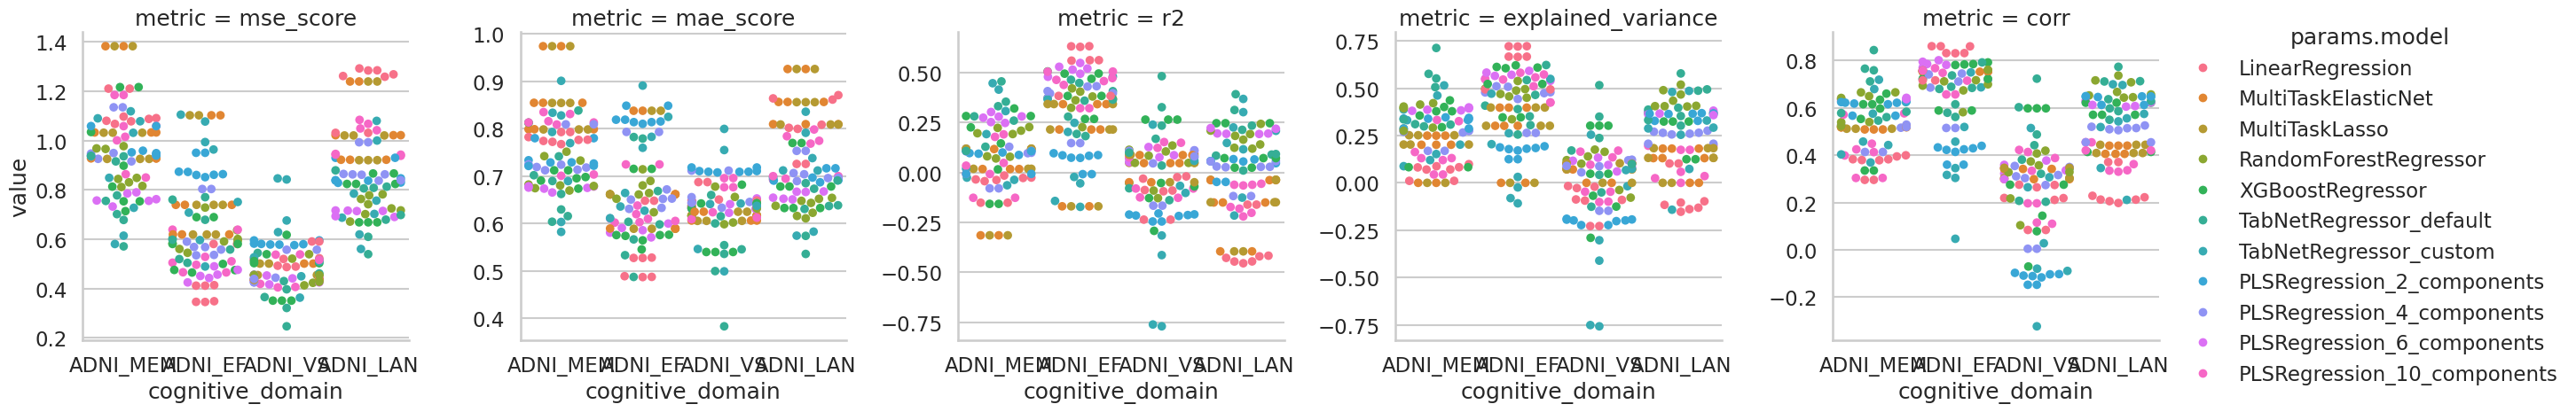

In [78]:
df_plot_split_ajd = df_results_split_radar[df_results_split_radar['result_domain'] == "results_adj"]
df_plot_split_org = df_results_split_radar[df_results_split_radar['result_domain'] == "results_org"]

sns.catplot(data=df_plot_split_ajd, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

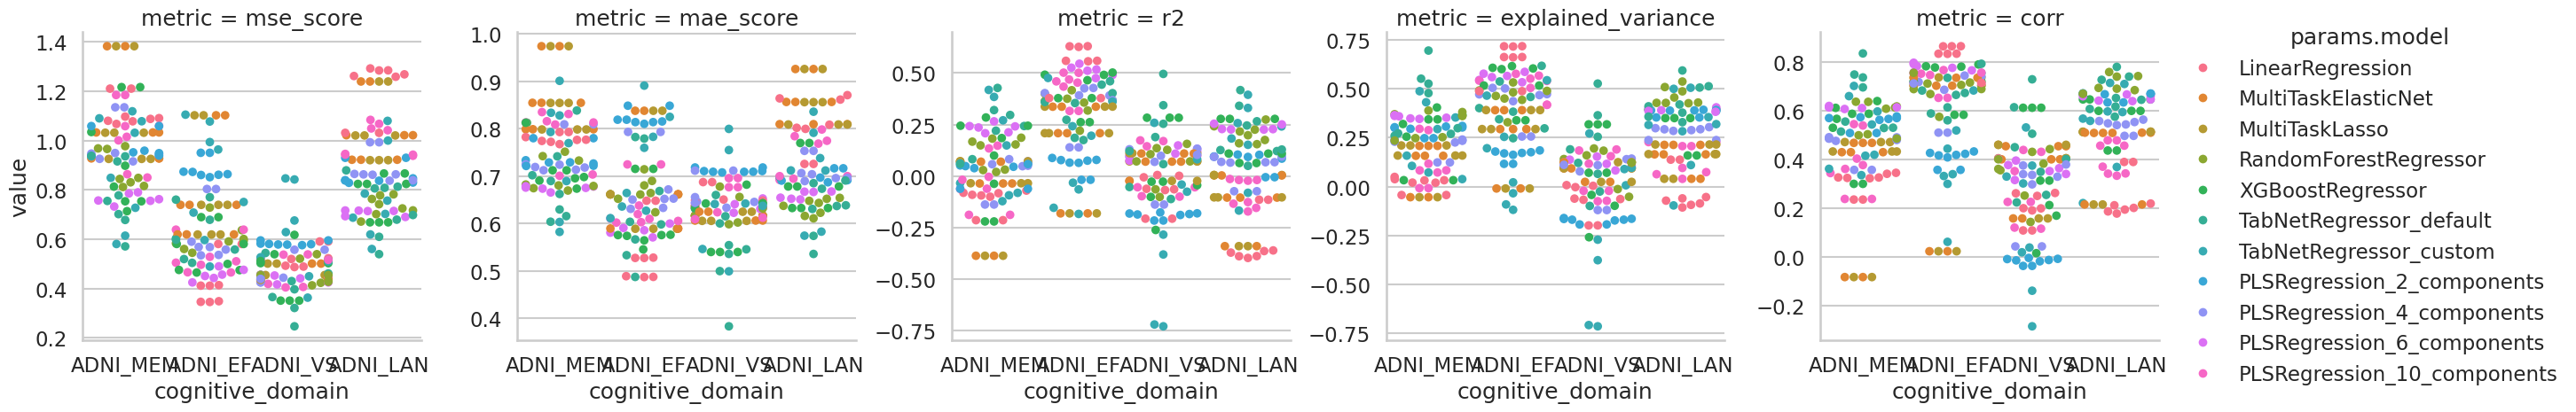

In [79]:
sns.catplot(data=df_plot_split_org, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)